In [89]:
import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, ai_path, real_path, img_size=(300, 300)):
        
        ai_images = [(p, 1) for p in glob.glob(ai_path)]
        real_images = [(p, 0) for p in glob.glob(real_path)]
        self.all_data = ai_images + real_images

        random.seed(42)
        random.shuffle(self.all_data)
        
        self.img_size = img_size
        
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    def __len__(self):
        return len(self.all_data)
    
    def __getitem__(self, idx):
        file_path, label = self.all_data[idx]
        
        img = Image.open(file_path).convert("RGB")
        img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.float32)

def get_dataloaders(ai_path, real_path, img_size=(300, 300), batch_size=32, val_split=0.2):

    dataset = MyDataset(ai_path, real_path, img_size)
    
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader

if __name__ == '__main__':
    ai_path = "./AI-Generated-vs-Real-Images-Datasets/AiArtData/AiArtData/*"
    real_path = "./AI-Generated-vs-Real-Images-Datasets/RealArt/RealArt/*"

    train_loader, val_loader = get_dataloaders(ai_path, real_path, img_size=(300, 300), batch_size=32, val_split=0.2)


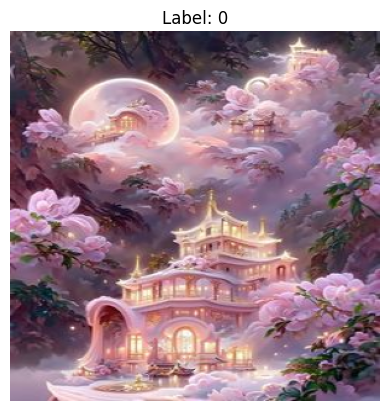

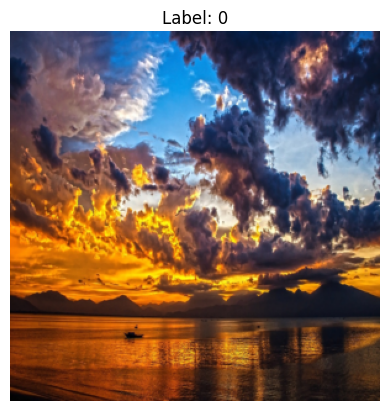

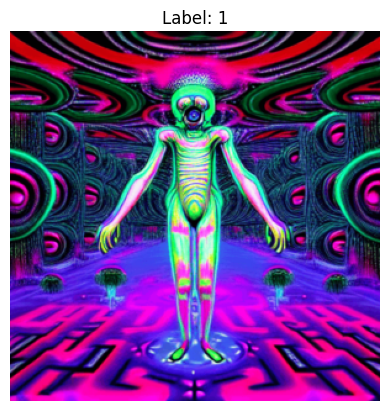

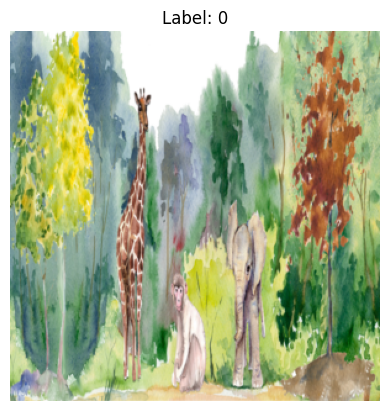

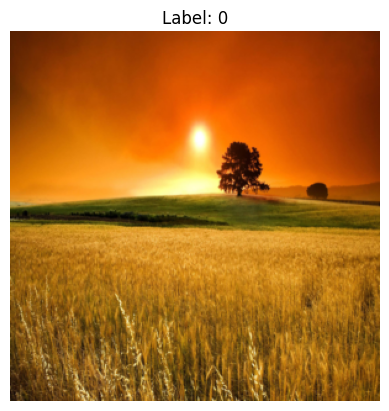

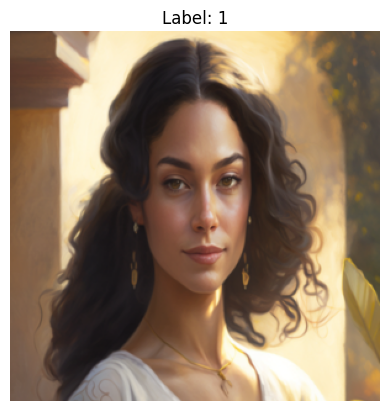

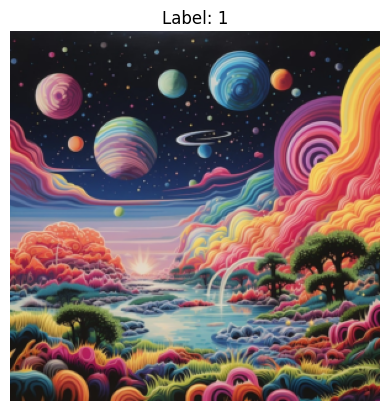

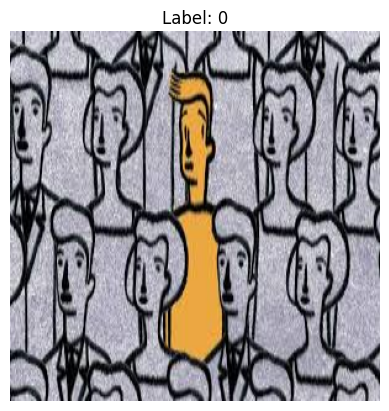

In [91]:
def show_image(img_tensor, label=None):
    transform_to_pil = transforms.ToPILImage()
    img = transform_to_pil(img_tensor)
    
    plt.imshow(img)
    if label is not None:
        plt.title(f"Label: {int(label)}")
    plt.axis('off')
    plt.show()

for images, labels in train_loader:
    for i in range(8):
        show_image(images[i], labels[i])
    break


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Сверточные слои
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, 300, 300]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, 300, 300]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 64, 150, 150]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [B, 128, 150, 150]
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # [B, 128, 150, 150]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 128, 75, 75]

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # [B, 256, 75, 75]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # [B, 256, 75, 75]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 256, 37, 37]
        )

        # Полносвязные слои
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 37 * 37, 512),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, 1),  # Выходной слой
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


model = ImprovedCNN()
print(model)

for images, labels in train_loader:
    outputs = model(images)
    print("Output shape:", outputs.shape) 
    break

ImprovedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=350464, out_features=512, bias=True)
    (2): Re

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.float().to(device), labels.float().to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.float().to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved at epoch {epoch+1} with Val Loss: {val_loss:.4f}')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f'No improvement for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in Val Loss.')
            break

    print(f'Training completed. Best Val Loss: {best_val_loss:.4f}')

    # Построение графика
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


Epoch 1/20, Loss: 0.8629, Val Loss: 0.6928, Learning Rate: 0.001
Best model saved at epoch 1 with Val Loss: 0.6928
Epoch 2/20, Loss: 0.6924, Val Loss: 0.6911, Learning Rate: 0.001
Best model saved at epoch 2 with Val Loss: 0.6911
Epoch 3/20, Loss: 0.6929, Val Loss: 0.6907, Learning Rate: 0.001
Best model saved at epoch 3 with Val Loss: 0.6907
Epoch 4/20, Loss: 0.6875, Val Loss: 0.6905, Learning Rate: 0.001
Best model saved at epoch 4 with Val Loss: 0.6905
Epoch 5/20, Loss: 0.6906, Val Loss: 0.6901, Learning Rate: 0.001
Best model saved at epoch 5 with Val Loss: 0.6901
Epoch 6/20, Loss: 0.6904, Val Loss: 0.6904, Learning Rate: 0.001
No improvement for 1 epoch(s).
Epoch 7/20, Loss: 0.6906, Val Loss: 0.6901, Learning Rate: 0.001
No improvement for 2 epoch(s).
Epoch 8/20, Loss: 0.6903, Val Loss: 0.6898, Learning Rate: 0.001
Best model saved at epoch 8 with Val Loss: 0.6898
Epoch 9/20, Loss: 0.6901, Val Loss: 0.6896, Learning Rate: 0.001
Best model saved at epoch 9 with Val Loss: 0.6896
Epo

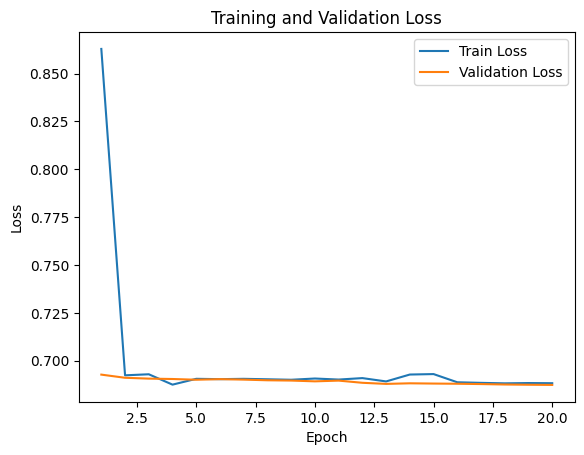

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


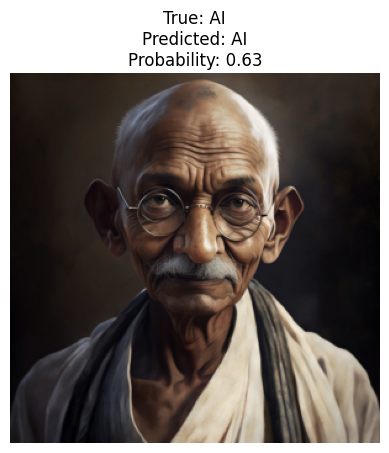

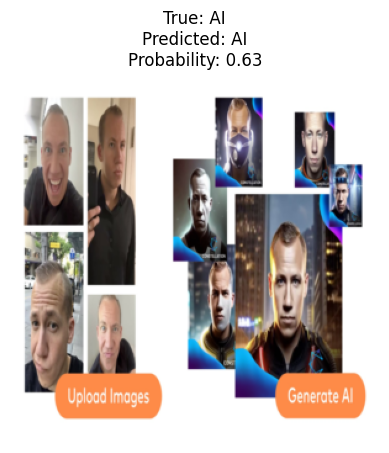

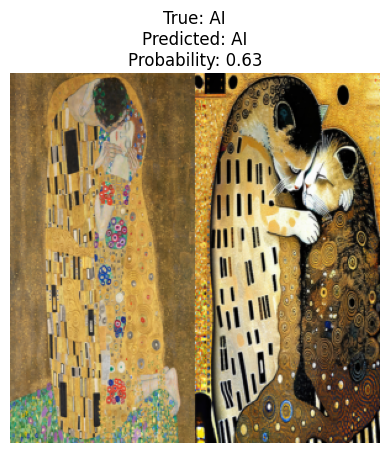

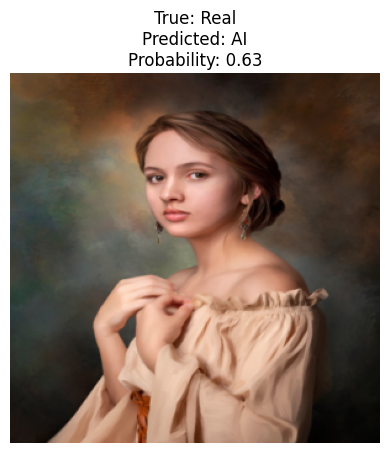

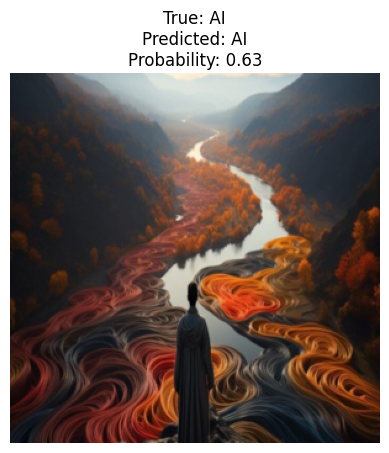

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

def show_image_with_prediction(img_tensor, true_label, predicted_label, probability):
    transform_to_pil = transforms.ToPILImage()
    img = transform_to_pil(img_tensor)

    plt.imshow(img)
    plt.title(f"True: {'AI' if true_label == 1 else 'Real'}\n"
              f"Predicted: {'AI' if predicted_label == 1 else 'Real'}\n"
              f"Probability: {probability:.2f}")
    plt.axis('off')
    plt.show()

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    shown_images = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze(1)
            probabilities = torch.sigmoid(outputs).cpu().numpy() 
            predicted_labels = (probabilities >= 0.5).astype(int)

            for i in range(len(images)):
                if shown_images >= num_images:
                    return
                show_image_with_prediction(
                    img_tensor=images[i].cpu(),
                    true_label=labels[i].item(),
                    predicted_label=predicted_labels[i],
                    probability=probabilities[i]
                )
                shown_images += 1

visualize_predictions(model, val_loader, device, num_images=5)


In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (outputs >= 0.5).float()  # Применение порога для классификации
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()

# Метрики
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


/Users/daniyar/notes/projects/ai_image_detector/env/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy: 0.5520
Precision: 0.5520
Recall: 1.0000
F1 Score: 0.7113
